In [ ]:
# if open from google colab, run this command
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/sales-prediction-gru/ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github/sales-prediction-gru/ipynb


In [ ]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model, callbacks

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Loading data

In [ ]:
df = pd.read_csv('../data/fakta_penjualan_unv_202112091006.csv')

In [ ]:
# df.info()

## Drop Column

In [ ]:
df = df.drop(['nonota', 'namabarang', 'satuan', 'hargajual', 'hargabeli', 'hargajual2', 'kodejenis', 'jenis', 'keuntungan', 'kodecabang', 'cabang'], axis=1)

In [ ]:
# df

## Drop Unique Symbol from Barcode Column & Convert QTY Column

In [ ]:
df['barcode'] = df['barcode'].astype(str).str[:13]
df['barcode'] = df['barcode'].astype(int)
df['qty'] = df['qty'].astype(int)

In [ ]:
# df.info()

## Split to Data Test & Data Train

In [ ]:
test = df[df['tahun']==2019]
# test.head()

In [ ]:
years = [2016, 2017, 2018]
train = df[df.tahun.isin(years)]
# train.head()

In [ ]:
# train.info()
# test.info()

## Transform Column to Date Column

In [ ]:
def column_to_date(data):
    # create date column from hari, bulan, tahun column
    cols = ["hari","bulan","tahun"]
    data['date'] = data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    
    # drop hari, bulan, tahun column
    data = data.drop(['hari', 'bulan', 'tahun'], axis=1)
    
    # transformn date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    return data

In [ ]:
test = column_to_date(test)
# test.head()

In [ ]:
train = column_to_date(train)
# train.head()

In [ ]:
# train.info()
# test.info()

## Get month number from Date

In [ ]:
train['month_yr'] = train['date'].apply(lambda x: x.strftime('%m-%y')).astype(str)

In [ ]:
train['month_yr'] = train['month_yr'].map({'01-16':0,'02-16':1,'03-16':2,'04-16':3,'05-16':4,'06-16':5,'07-16':6,'08-16':7,'09-16':8,'10-16':9,'11-16':10,'12-16':11,
                                          '01-17':12,'02-17':13,'03-17':14,'04-17':15,'05-17':16,'06-17':17,'07-17':18,'08-17':19,'09-17':20,'10-17':21,'11-17':22,'12-17':23,
                                          '01-18':24,'02-18':25,'03-18':26,'04-18':27,'05-18':28,'06-18':29,'07-18':30,'08-18':31,'09-18':32,'10-18':33,'11-18':34,'12-18':35})

In [ ]:
train['month_yr'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [ ]:
print(f"Min date from data set: {test['date'].min().date()}")
print(f"Max date from data set: {test['date'].max().date()}")

Min date from data set: 2019-01-01
Max date from data set: 2019-12-31


In [ ]:
print(f"Min date from data set: {train['date'].min().date()}")
print(f"Max date from data set: {train['date'].max().date()}")

Min date from data set: 2016-01-01
Max date from data set: 2018-12-31


In [ ]:
# train.info()
# test.info()

## Prepare test dataset

Leaving only the barcode that exist in the test set to have more accurate results.
Drop kodejenis, qty and date column

In [ ]:
test = test.drop(['qty', 'date'], axis=1)
# test.head()

In [ ]:
# test_barcode = test['barcode'].unique()
# Only items that exist in test set.
# train = train[train['barcode'].isin(test_barcode)]

## Data preprocessing

- We are asked to predict total sales for every product in the next month, and our data is given by day, so let's aggregate the data by month.
- Also I'm leaving only monthly "item_cnt" >= 0 and <= 20, as this seems to be the distributions of the test set.

In [ ]:
train_monthly = train[['date', 'month_yr', 'barcode', 'qty']]
train_monthly = train_monthly.sort_values('date').groupby(['month_yr', 'barcode'], as_index=False)
train_monthly = train_monthly.agg({'qty':['sum']})
train_monthly.columns = ['month_yr', 'barcode', 'qty_cnt']
train_monthly = train_monthly.query('qty_cnt >= 0 and qty_cnt <= 50')

# Label
train_monthly['qty_cnt_month'] = train_monthly.sort_values('month_yr').groupby(['barcode'])['qty_cnt'].shift(-1)

display(train_monthly.head())
# display(train_monthly.describe())

,month_yr,barcode,qty_cnt,qty_cnt_month
0,0,4800888137319,15,23.00
1,0,4800888141101,46,41.00
3,0,4800888157942,23,21.00
4,0,4800888157959,11,13.00
5,0,4800888157966,46,37.00


In [ ]:
# train_monthly.info()

## Time-Series Processing

- As I only need the "qty_cnt" feature as a series, I can get that easily by just using a pivot operation.
- This way I'll also get the missing months from each "barcode", and then replace them with 0 (otherwise would be "nan").

In [ ]:
monthly_series = train_monthly.pivot_table(index=['barcode'], columns='month_yr',values='qty_cnt', fill_value=0).reset_index()
monthly_series.head()

month_yr,barcode,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,4800888137319,15,23,23,12,23,17,22,14,9,...,16,15,15,9,17,11,13,14,14,13
1,4800888141101,46,41,42,48,34,32,45,42,40,...,0,0,0,0,0,0,0,0,0,0
2,4800888141125,0,0,0,0,0,0,0,0,49,...,0,0,0,0,0,35,13,41,0,0
3,4800888157942,23,21,29,32,19,26,19,24,12,...,1,2,2,0,1,5,4,1,1,4
4,4800888157959,11,13,12,13,9,5,5,4,7,...,8,11,4,10,5,6,6,3,3,7


In [ ]:
# only test

# monthly_series
# monthly_series['barcode'].unique()
# monthly_series[monthly_series.duplicated(subset=['barcode'],keep=False)]
# monthly_series.info()

Currently I have one series (35 months) for each unique pair of "barcode", but probably would be better to have multiple smaller series for each unique pair, so I'm generating multiple series of size 12 (one year) for each unique pair

In [ ]:
first_month = 23
last_month = 35
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['barcode']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['barcode']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,barcode,0,1,2,3,4,5,6,7,8,9,10,11,label
0,4800888137319,7,21,11,16,15,15,9,17,11,13,14,14,13
1,4800888141101,5,0,0,0,0,0,0,0,0,0,0,0,0
2,4800888141125,24,26,0,0,0,0,0,0,35,13,41,0,0
3,4800888157942,9,19,13,1,2,2,0,1,5,4,1,1,4
4,4800888157959,5,6,10,8,11,4,10,5,6,6,3,3,7


In [ ]:
data_series

,barcode,0,1,2,3,4,5,6,7,8,9,10,11,label
0,4800888137319,7,21,11,16,15,15,9,17,11,13,14,14,13
1,4800888141101,5,0,0,0,0,0,0,0,0,0,0,0,0
2,4800888141125,24,26,0,0,0,0,0,0,35,13,41,0,0
3,4800888157942,9,19,13,1,2,2,0,1,5,4,1,1,4
4,4800888157959,5,6,10,8,11,4,10,5,6,6,3,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,9300830042982,0,3,1,1,1,0,1,0,0,0,1,1,1
1306,9300830043002,0,0,3,0,1,1,0,1,0,1,4,8,10
1307,9300830043521,0,6,7,6,4,4,5,3,2,4,25,15,18
1308,9310158111567,0,1,1,3,6,5,5,5,4,11,9,5,5


## Dropping identifier columns as we don't need them anymore

In [ ]:
data_series = data_series.drop(['barcode'], axis=1)

# series = monthly_series.drop(['barcode'], axis=1)

## Train and validation sets

In [ ]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

# train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, shuffle=False)

# train_size = int(len(data_series)*0.8)
# train_data = data_series.iloc[:train_size]
# test_data = data_series.iloc[train_size:]

In [ ]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

# print("Train set", train_scaled.shape)
# print("Test set", test_scaled.shape)

Train set (1179, 12)
Validation set (131, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
184,37,0,46,37,47,41,41,47,0,9,13,8
418,27,0,45,0,0,19,20,38,44,42,45,34
295,0,0,0,0,0,0,0,0,0,0,0,0
14,5,4,8,7,10,6,19,10,15,13,2,9
1046,0,2,3,8,14,12,8,6,5,5,7,1


## Reshape data.

- Time-series shape (data points, time-steps, features).

In [ ]:
train.shape

(1179, 12)

In [ ]:
# scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(-1, 1))
# x_train_scaled = scaler.fit_transform(train)
# x_valid_scaled = scaler.fit_transform(valid)

# scaler = MinMaxScaler().fit(train)
# x_train_scaled = scaler.transform(train)
# x_valid_scaled = scaler.transform(valid)

In [ ]:
# X_train = x_train_scaled.reshape((x_train_scaled.shape[0], x_train_scaled.shape[1], 1))
# X_valid = x_valid_scaled.reshape((x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1))
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (1179, 12, 1)
Validation set reshaped (131, 12, 1)


## Regular GRU model.

In [ ]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 1000
batch = 64
lr = 0.0001

gru_model = Sequential()
gru_model.add(L.GRU(10, input_shape=(serie_size, n_features), return_sequences=True))
# gru_model.add(L.GRU(6, activation='relu', return_sequences=True))
gru_model.add(L.GRU(1, activation='relu'))
gru_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
# gru_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
gru_model.add(L.Dense(1))
gru_model.summary()

adam = optimizers.Adam(lr)
gru_model.compile(loss='mse', optimizer=adam)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 12, 10)            390       
                                                                 
 gru_8 (GRU)                 (None, 1)                 39        
                                                                 
 dense_7 (Dense)             (None, 10)                20        
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 460
Trainable params: 460
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = callbacks.EarlyStopping(patience = 5)
gru_history = gru_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2,
                              callbacks=[early_stop])

Epoch 1/1000
19/19 - 5s - loss: 262.5047 - val_loss: 298.0315 - 5s/epoch - 253ms/step
Epoch 2/1000
19/19 - 0s - loss: 262.2119 - val_loss: 297.6943 - 268ms/epoch - 14ms/step
Epoch 3/1000
19/19 - 0s - loss: 261.9134 - val_loss: 297.3453 - 268ms/epoch - 14ms/step
Epoch 4/1000
19/19 - 0s - loss: 261.6042 - val_loss: 296.9941 - 261ms/epoch - 14ms/step
Epoch 5/1000
19/19 - 0s - loss: 261.2954 - val_loss: 296.6276 - 259ms/epoch - 14ms/step
Epoch 6/1000
19/19 - 0s - loss: 260.9749 - val_loss: 296.2584 - 269ms/epoch - 14ms/step
Epoch 7/1000
19/19 - 0s - loss: 260.6477 - val_loss: 295.8901 - 262ms/epoch - 14ms/step
Epoch 8/1000
19/19 - 0s - loss: 260.3199 - val_loss: 295.5085 - 274ms/epoch - 14ms/step
Epoch 9/1000
19/19 - 0s - loss: 259.9825 - val_loss: 295.1184 - 263ms/epoch - 14ms/step
Epoch 10/1000
19/19 - 0s - loss: 259.6321 - val_loss: 294.7222 - 294ms/epoch - 15ms/step
Epoch 11/1000
19/19 - 0s - loss: 259.2751 - val_loss: 294.3092 - 256ms/epoch - 13ms/step
Epoch 12/1000
19/19 - 0s - loss:

###### Model training

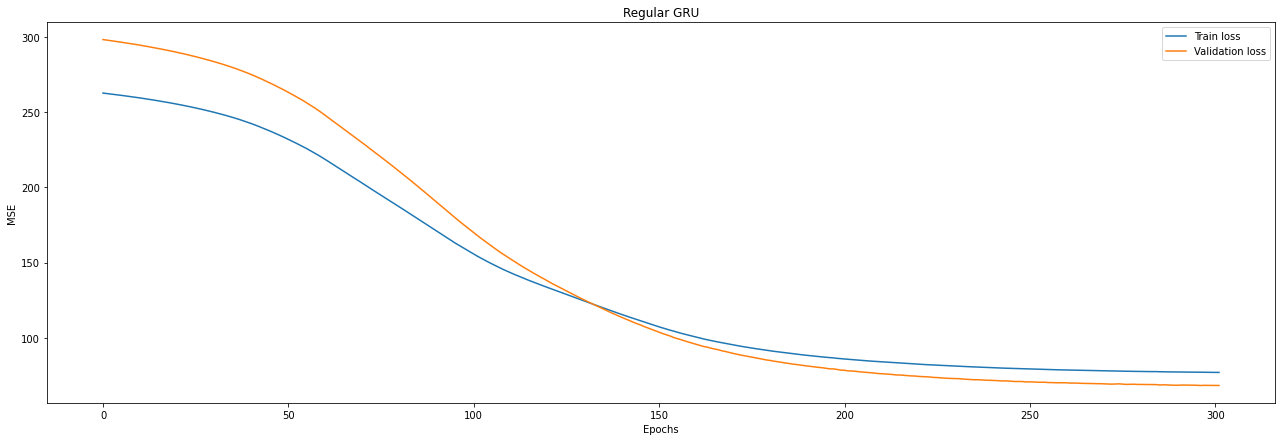

In [ ]:
fig, ax1 = plt.subplots(1, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular GRU')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

plt.show()

##### Regular GRU on train and validation

In [ ]:
# X_train_inversed = scaler.inverse_transform(X_train)
# X_valid_inversed = scaler.inverse_transform(X_valid)

In [ ]:
# lstm_train_pred = gru_model.predict(X_train_inversed)
# lstm_val_pred = gru_model.predict(X_valid_inversed)
lstm_train_pred = gru_model.predict(X_train)
lstm_val_pred = gru_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

Train rmse: 8.7739497504393
Validation rmse: 8.267619365636085


In [ ]:
X_train.shape

(1179, 12, 1)

In [ ]:
lstm_val_pred.shape

(131, 1)

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(valid, Y_valid, label='Actual')
# ax.plot(valid, lstm_val_pred, label='Predicted')
# plt.title('GRU Prediction vs Actual Sales for last 3 months')
# plt.xlabel('Month')
# plt.xticks(valid)
# plt.ylabel('Sales of Barcode 4800888137319')
# ax.legend()
# plt.show()

##### Build test set

In [ ]:
# cc = [test.duplicated(subset=['barcode'],keep=False)]
cc = test.groupby(test.columns.tolist(),as_index=False).size()
cc

,barcode,size
0,4800888137319,83
1,4800888141125,795
2,4800888157942,76
3,4800888157959,111
4,4800888157966,258
...,...,...
1033,9300830042913,127
1034,9300830042982,56
1035,9300830043002,20
1036,9300830043521,237


In [ ]:
clean_test = test.drop_duplicates(subset=['barcode'])

In [ ]:
clean_test

,barcode
1096038,8999999407919
1096039,8999999500399
1096040,8999999003067
1096041,8999999045579
1096042,8992747180225
...,...
1439870,8999999553135
1440591,8999999552541
1441150,8999999552534
1441974,8999999553111


In [ ]:
monthly_series

month_yr,barcode,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,4800888137319,15,23,23,12,23,17,22,14,9,...,16,15,15,9,17,11,13,14,14,13
1,4800888141101,46,41,42,48,34,32,45,42,40,...,0,0,0,0,0,0,0,0,0,0
2,4800888141125,0,0,0,0,0,0,0,0,49,...,0,0,0,0,0,35,13,41,0,0
3,4800888157942,23,21,29,32,19,26,19,24,12,...,1,2,2,0,1,5,4,1,1,4
4,4800888157959,11,13,12,13,9,5,5,4,7,...,8,11,4,10,5,6,6,3,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,9300830042982,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,1,1,1
1306,9300830043002,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,4,8,10
1307,9300830043521,0,0,0,0,0,0,0,0,0,...,6,4,4,5,3,2,4,25,15,18
1308,9310158111567,0,0,0,0,0,0,0,0,0,...,3,6,5,5,5,4,11,9,5,5


In [ ]:
latest_records = monthly_series.drop_duplicates(subset=['barcode'])
X_test = pd.merge(clean_test, latest_records, on=['barcode'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['barcode'], axis=1, inplace=True)
X_test

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,47.00,44.00,42.00,45.00,28.00,0.00,26.00,29.00,37.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,49.00,0.00,39.00,0.00,0.00,35.00,47.00,15.00,16.00,39.00,...,47.00,0.00,35.00,41.00,0.00,0.00,0.00,0.00,46.00,43.00
3,0.00,0.00,0.00,44.00,50.00,48.00,0.00,44.00,39.00,0.00,...,34.00,39.00,17.00,40.00,39.00,40.00,44.00,19.00,10.00,33.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1034,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1035,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1036,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
latest_records

month_yr,barcode,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,4800888137319,15,23,23,12,23,17,22,14,9,...,16,15,15,9,17,11,13,14,14,13
1,4800888141101,46,41,42,48,34,32,45,42,40,...,0,0,0,0,0,0,0,0,0,0
2,4800888141125,0,0,0,0,0,0,0,0,49,...,0,0,0,0,0,35,13,41,0,0
3,4800888157942,23,21,29,32,19,26,19,24,12,...,1,2,2,0,1,5,4,1,1,4
4,4800888157959,11,13,12,13,9,5,5,4,7,...,8,11,4,10,5,6,6,3,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,9300830042982,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,1,1,1
1306,9300830043002,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,4,8,10
1307,9300830043521,0,0,0,0,0,0,0,0,0,...,6,4,4,5,3,2,4,25,15,18
1308,9310158111567,0,0,0,0,0,0,0,0,0,...,3,6,5,5,5,4,11,9,5,5


##### Regular LSTM model test predictions
- For the regular LSTM model we just need the last 12 months, because that's our series input size.

In [ ]:
X_test = X_test[[(i + (36 - serie_size)) for i in range(serie_size)]]
X_test.head()

,24,25,26,27,28,29,30,31,32,33,34,35
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,47.00,0.00,35.00,41.00,0.00,0.00,0.00,0.00,46.00,43.00
3,40.00,41.00,34.00,39.00,17.00,40.00,39.00,40.00,44.00,19.00,10.00,33.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


##### Reshape data.
- Time-series shape (data points, time-steps, features).

In [ ]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(1038, 12, 1)


##### Making predictions.

In [ ]:
lstm_test_pred = gru_model.predict(X_test_reshaped)

##### Predictions from the regular GRU model.

In [ ]:
lstm_test_pred

array([[ 1.6239933],
       [ 1.6239933],
       [25.012695 ],
       ...,
       [ 1.6239933],
       [ 1.6239933],
       [ 1.6239933]], dtype=float32)

In [ ]:
lstm_prediction = pd.DataFrame(clean_test['barcode'], columns=['barcode'])
lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 50.)
lstm_prediction.head
# a
# lstm_prediction.to_csv('gru_submission.csv', index=False)

<bound method NDFrame.head of                barcode  item_cnt_month
1096038  8999999407919            1.62
1096039  8999999500399            1.62
1096040  8999999003067           25.01
1096041  8999999045579           23.34
1096042  8992747180225            1.62
...                ...             ...
1439870  8999999553135            1.62
1440591  8999999552541            1.62
1441150  8999999552534            1.62
1441974  8999999553111            1.62
1445435  8999999552442            1.62

[1038 rows x 2 columns]>

In [ ]:
# lstm_prediction.to_csv('gru_test.csv', index=False)